<a href="https://colab.research.google.com/github/btaute/notebooks/blob/main/Bifacial_SAT_Utility_Scale_PV_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [1]:
!pip install pvlib[optional] # optional installs PVFactors, too.
import pvlib
from pvlib.pvsystem import SingleAxisTrackerMount, Array, PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output 

clear_output()
print(pvlib.__version__)

0.9.0


In [2]:
nrel_api_key = '' # Enter your own API Key
nrel_email = '' # Enter your own email

# Custom Functions

In [3]:
def get_degradation_loss_factor(degradation_years=0,
                                lid = .01,
                                first_year_degradation=.02,
                                annual_degradation=.0035):
  # Assuming a scalar value for the full year right now.
  # This means the degradation rate is calculated at the midyear
  # TODO: This can easily be updated to a timeseries calc
  # TODO: Check how function should handle possibility of negative inputs

  if first_year_degradation < lid:
    raise ValueError('first_year_degradation should include lid and thus be a greater value.')
  
  if degradation_years == 0:
    midyear_degradation = (lid + first_year_degradation) / 2
  else:
    midyear_degradation = first_year_degradation + \
                          annual_degradation * (degradation_years - 1) + \
                          annual_degradation / 2

  return midyear_degradation

def get_racking_width(module_orientation='1P', module_height=2, module_width=1):
  #TODO: Make more flexible (Parse the input orientation for int and L/P)

  if module_orientation not in ['1P', '2P', '4L']:
    raise ValueError('Please use module_orientation of "1P", "2P", or "4L".')

  if module_orientation == '1P':
    return 1 * module_height
  elif module_orientation == '2P':
    return 2 * module_height
  else:
    return module_width * 4

In [4]:
def combine_loss_factors(losses, index=None, fill_method='ffill'):
  # losses can be scalars or pd.Series with a datetimeIndex.
  # Note that reindexing a Series that isn't monotonoically decreasing/increasing fails
  # So this function isn't too helpful for TMYs.  You must already have each Series match the TMY index.

  def _split_losses_into_scalars_and_series():
    scalar_losses = []
    series_losses = []
    for loss in losses:
      if isinstance(loss, pd.Series):
        series_losses.append(loss)
      elif np.isscalar(loss):
        scalar_losses.append(loss)
      else:
        raise ValueError('Not all losses provided are pd.Series or scalars')
    return scalar_losses, series_losses
  
  def _check_series_have_DatetimeIndex():
    for loss in series_losses:
      if not isinstance(loss.index, pd.DatetimeIndex):
        raise ValueError("Series loss doesn't have a pd.DatetimeIndex.")
  
  def _check_input_index():
    if not isinstance(index, pd.DatetimeIndex):
      raise ValueError('Index provided is not a pd.DatetimeIndex.')
  
  def _find_index_from_series_losses(series_losses):
    return series_losses[0].index

  def _set_index(index):
    if index is None:
      return _find_index_from_series_losses(series_losses)
    else:
      _check_input_index()
      return index
  
  def _reindex_series_losses(series_losses, index):
    return [loss.reindex(index, method=fill_method) for loss in series_losses]

  scalar_losses, series_losses = _split_losses_into_scalars_and_series()
  if len(series_losses) > 0:
    _check_series_have_DatetimeIndex()
    index = _set_index(index)
    series_losses = _reindex_series_losses(series_losses, index)
  
  combined_factor = 1
  for loss in series_losses + scalar_losses:
    combined_factor *= (1 - loss)
  return 1 - combined_factor

In [5]:
def build_monthly_series(index, month_values):
  if len(month_values) != 12:
    raise AttributeError('Length of month_values is not 12.')
  
  series = pd.Series()

  for i in range(12):
    series = series.append(pd.Series(month_values[i], index=index[index.month == i+1]))

  return series

# Define Project Parameters

In [6]:
# Location Parameters
lat = 40.5257 # Bertrand, NE
lon = -99.6339 # Bertrand, NE

# Project Parameters
poi_mw_ac = 100
poi_kv = 34.5
plant_mw_ac = poi_mw_ac / .9 # oversize for power factor and temp degradation
plant_mw_dc = poi_mw_ac * 1.25
bifacial = True # Not incorporated: Modeling every plant as bifacial right now
tracking = 'Single Axis' # Fixed Tilt, Single Axis, Double Axis; # Not incorporated: Modeling every plant as SAT right now
module_orientation = '1P' # 1P, 2P, 4L
year = 'tmy' # 1998:2020, tmy
project_name = 'Taute Solar'
past_operating_years = 0 # Used for module degradation

# Module Parameters
temp_coeff = -.0037
bifaciality = 0.75
module_efficiency = 0.19
ashrae_coeff = .03
module_height_m = 2 # Used in racking definition
module_width_m = 1 # Used in racking definition

module_parameters = {
    'pdc0': plant_mw_dc, # Simplified dc/ac models
    'gamma_pdc': temp_coeff,
    'bifaciality': bifaciality,
    'efficiency': module_efficiency,
    'b': ashrae_coeff
}

axis_tilt = 0
axis_azimuth = 180
max_angle = 60
backtrack = True
gcr = .33
racking_back = 'open_rack'
racking_width_m = get_racking_width(module_orientation, module_height_m, module_width_m)

# Array Parameters
surface_type = 'grass'
module_back = 'glass_glass' # glass_glass, glass_polymer
modules_per_string = 1 # Simplified ac/dc models
strings_per_inverter = 1 # Simplified ac/dc models
array_losses_parameters = 'dc_ohmic_percent' # Not used in current model

# PVSystem Paramters
inverter_efficiency_peak = .99
power_factor = .95 # Not really used right now
inverter_mw_ac = plant_mw_ac # Simplified dc/ac models
inverter_parameters = {'pdc0': inverter_mw_ac,
                       'eta_inv_nom': inverter_efficiency_peak}

# Cell Temp Model Parameters (based on racking/module type)
# https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.temperature.sapm_cell.html?highlight=sapm_temp
sapm_cell_temp_a = -3.47 # glass/glass, open rack
sapm_cell_temp_b = -0.0594 # glass/glass, open rack
sapm_cell_temp_deltaT = 3 # glass/glass, open rack

In [7]:
# Irradiance Losses

## rear (Bifacial Models Only)
rear_shading = .01 # fraction; amount of module backside shaded by racking
rear_reflection_loss = .05 # fraction; amount of backside irradiance lost to surface reflection
rear_soiling = .01 # fraction; amount of irradiance lost to backside soiling
rear_mismatch = .1 # % of "bifacial boost" lost to mismatch of backside irradiance across modules
rear_loss_factors = [rear_shading, rear_reflection_loss, rear_soiling, rear_mismatch]
rear_loss_fraction = combine_loss_factors(rear_loss_factors)

## front
spectral_irradiance_modifier = 1 # Used in Effective Irradiance Calc
front_diffuse_irradiance_reflection_loss = .03 # Used in Effective Irradiance Calc
# soiling loss can be timeseries, based on weather inputs (like precipitation and wind speed)
# or an annual scalar value, or monthly scalar values.
# Scalar values will be converted to a timeseries format matching weather index
# Right now, model only assumes monthly values
monthly_soiling_values = [.05, .05, .04, .03, .02, .02, .02, .02, .02, .03, .03, .04]

# DC Capacity Losses
# Detailed models will update voltage/current points for the single-diode model
# but simplified to just capacity adjustments for vendor-agnostic use-case

## Degradation
lid = .01 # fraction; Light Induced Degradation
first_year_degradation = .02 # fraction; Degradation expected after year 1 (includes LID)
annual_degradation = .0035 # fraction; Annual degradation after year 1

module_degradation = get_degradation_loss_factor(past_operating_years, lid,
                                                 first_year_degradation,
                                                 annual_degradation)

## Modules are binned higher than their rating (5W bins)
module_capacity_adjustment = -.01 # fraction, negative means increase in capacity

## Mismatch
module_mismatch = .01 # Mismatch between module capacities installed in one string
string_mismatch = .01 # Mismatch between operating outputs of connected modules
# Shading Electrical Effects
shading_mismatch = 0 # Mismatch caused by unequal beam shading of connected modules

dc_capacity_factors = [module_capacity_adjustment, module_degradation, module_mismatch, string_mismatch, shading_mismatch]
dc_capacity_loss = combine_loss_factors(dc_capacity_factors)

# DC Losses (After dc output model)
dc_cabling_loss_fraction = .015
dc_loss_factor = combine_loss_factors([dc_cabling_loss_fraction])

# PVSystem Losses (AC through powerblock / central inverter)

## Medium Voltage Transformer (1 per powerblock / central inverter; steps power up to 34.5kV)
# Detailed models would use actual equipment specs, not rules of thumb as used here
mvt_rating = inverter_mw_ac * 1.1
mvt_peak_loss = .007 * mvt_rating
mvt_constant_loss = .0013 * mvt_rating

# Plant Losses (AC from powerblock through POI)

## AC Cabling connecting PVSystems
ac_collection_loss_fraction = .005

## Main Power Transformer (1 or few per plant; Steps power up to POI Voltage)
# Detailed models would use actual equipment specs, not rules of thumb as used here
mpt_top_rating = plant_mw_ac * 1.1 # For large project capacities, multiple MPTs will be used
mpt_bottom_rating = mpt_top_rating * .6
mpt_peak_loss = .0017 * mpt_top_rating
mpt_constant_loss = .0004 * mpt_top_rating

## Cable losses connecting from Main Power Transformer to Point Of Interconnection
transmission_loss_fraction = .003 
    
# Intermittent Losses
# Get applied to P50 AEP but not a timeseries result (8760)
# Since we wouldn't predict these at any time interval
# (i.e. We don't know when an inverter will fail)
#TODO: Method could be improved
availability_loss = .01 # factor; downtime due to project maintenance
curtailment_loss = 0 # factor; grid operator scheduled curtailment
intermittent_loss_factors = [availability_loss, curtailment_loss]
intermittent_loss_fraction = combine_loss_factors(intermittent_loss_factors)

# Get Weather

In [8]:
psm3 = pvlib.iotools.get_psm3(lat, lon, nrel_api_key, nrel_email, year)
weather_metadata = psm3[1]
weather = psm3[0]

In [9]:
tmy = weather.copy()
tmy.columns = tmy.columns.str.replace(" ", "_").str.lower()
tmy = tmy.rename(columns={'temperature': 'temp_air'})

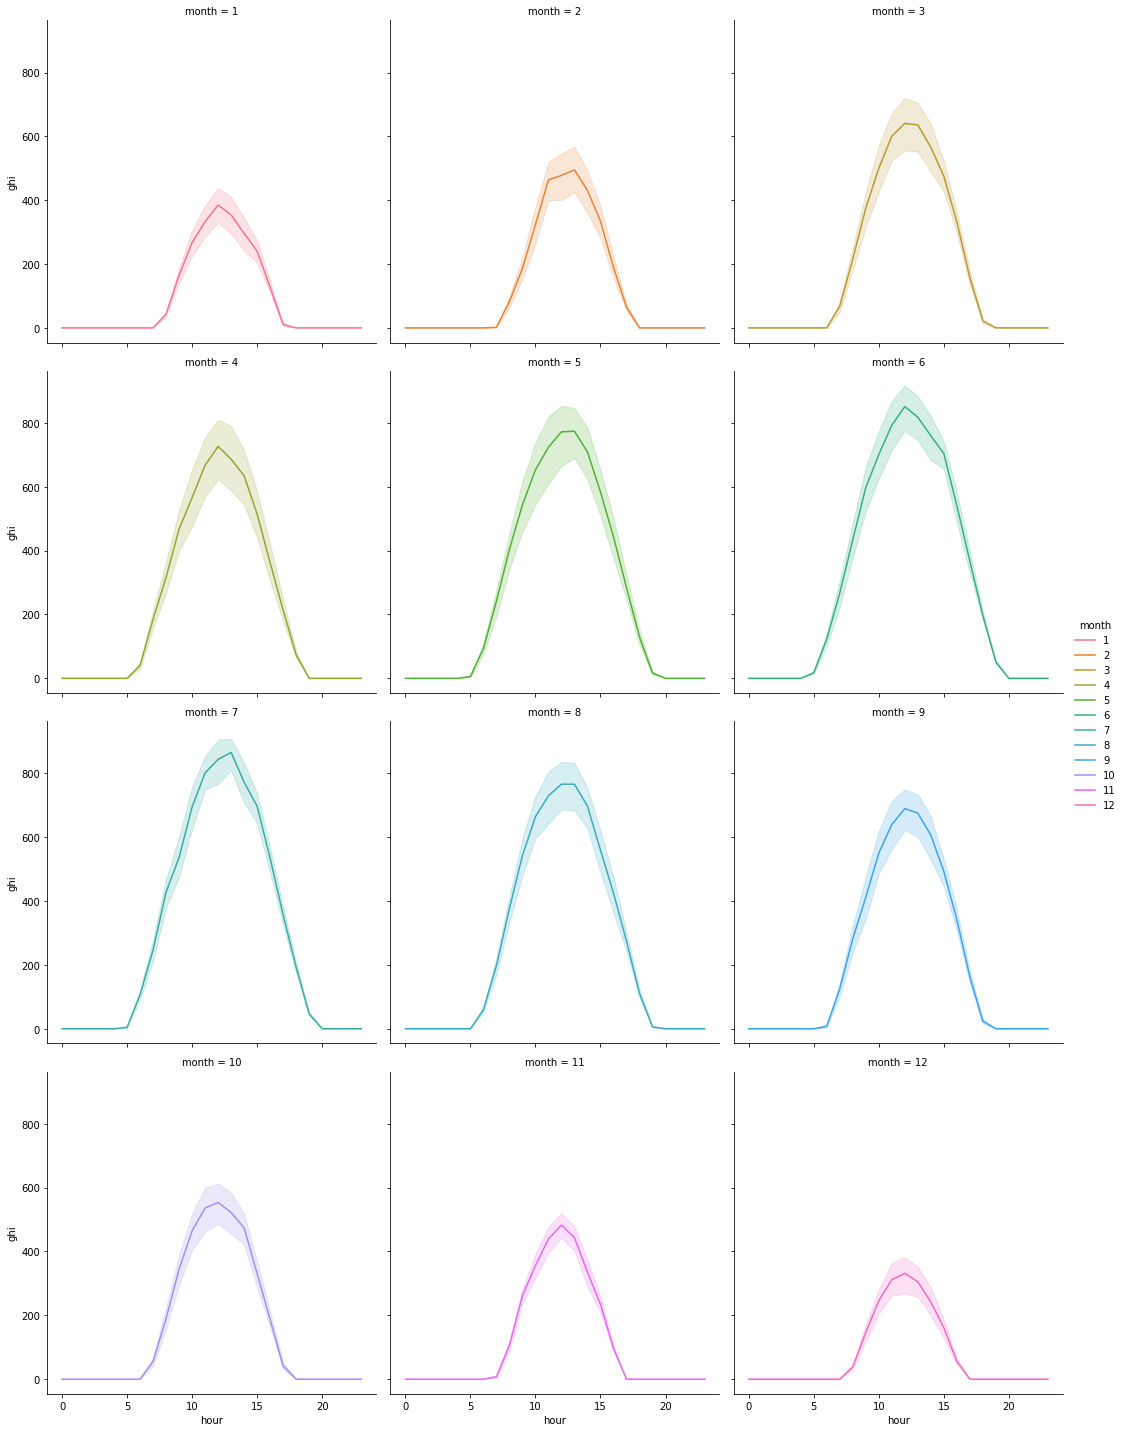

In [10]:
sns.relplot(data=tmy, x='hour', y='ghi', hue=tmy.month.astype('category'),
            col='month', col_wrap=3, kind='line')

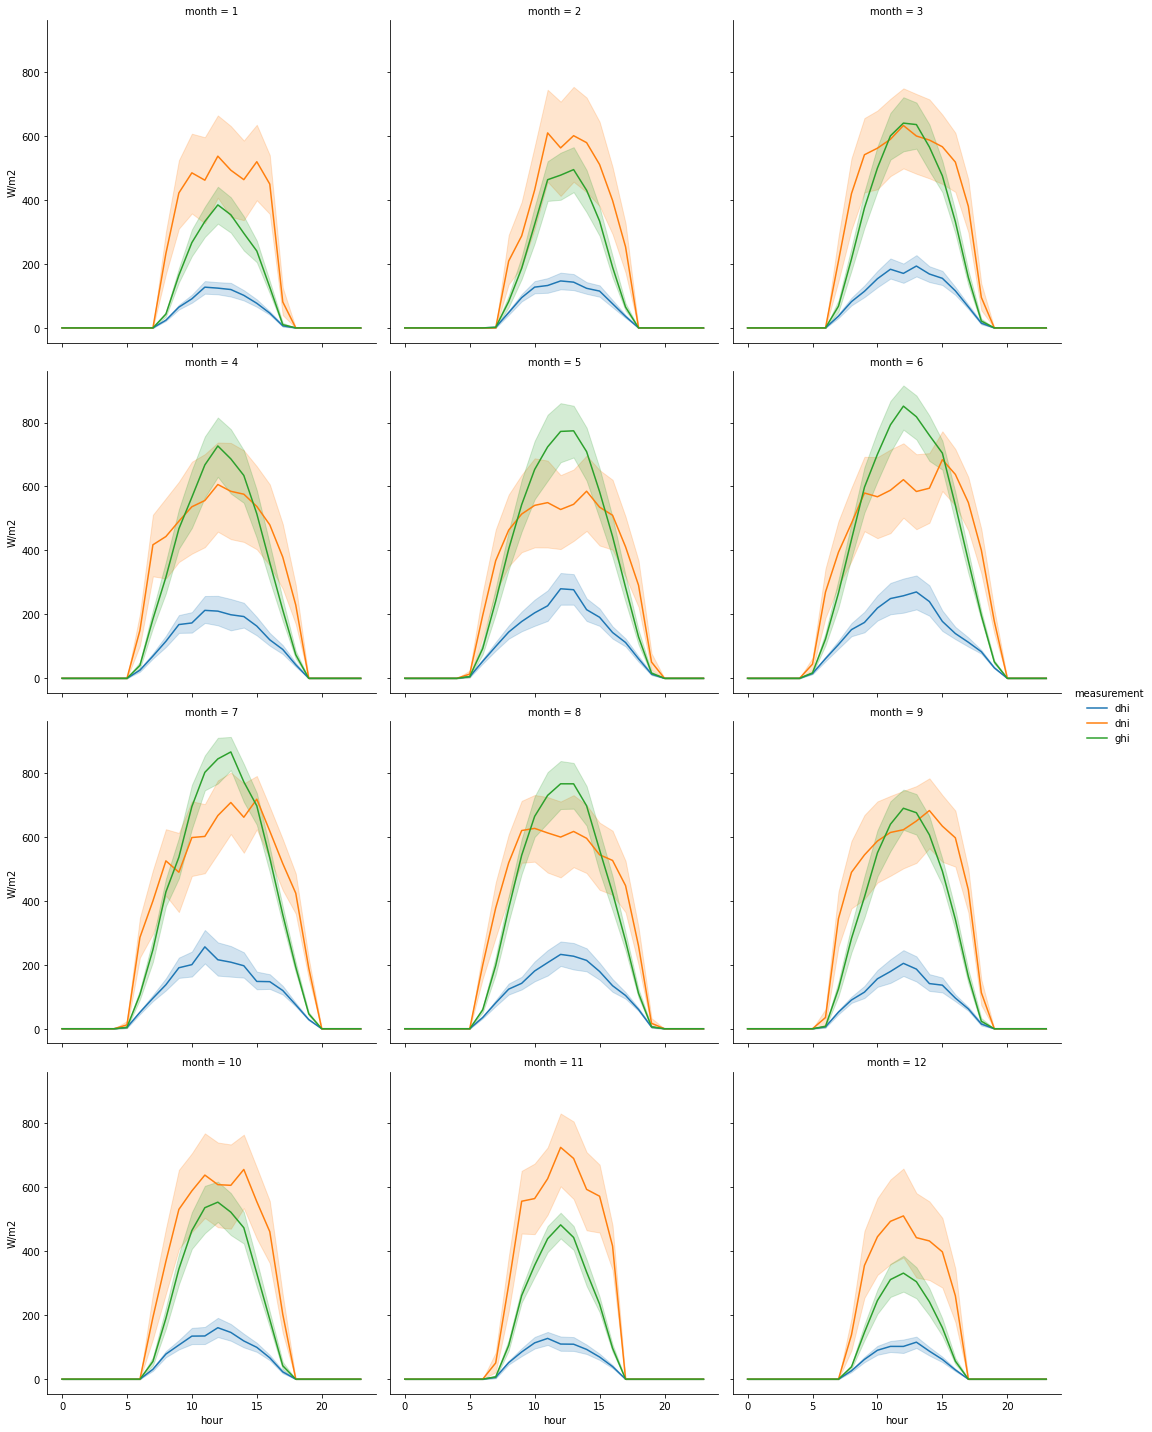

In [11]:
# GHI / DHI / DNI Plot

df = (tmy.loc[:,['dhi','dni','ghi','month','day', 'hour']]
    .melt(id_vars=['month','day', 'hour'],
          value_vars=['dhi', 'dni', 'ghi'],
          var_name='measurement',
          value_name='W/m2')
)

sns.relplot(data=df, x='hour', y='W/m2',
            hue='measurement', col='month',
            col_wrap=3, kind='line')

# Set Up a PVSystem and Location

In [12]:
mount = SingleAxisTrackerMount(axis_tilt=axis_tilt,
                               axis_azimuth=axis_azimuth,
                               max_angle=max_angle, backtrack=backtrack,
                               gcr=gcr, racking_model=racking_back,
                               module_height=module_height_m)

array = Array(mount, surface_type=surface_type,
              module_type=module_back,
              module_parameters=module_parameters,
              modules_per_string=modules_per_string,
              strings=strings_per_inverter,
              array_losses_parameters=array_losses_parameters)

system = PVSystem([array],racking_model=racking_back,
                  inverter_parameters=inverter_parameters)

location = Location(lat, lon,
                    tz=weather_metadata['Time Zone'],
                    altitude=weather_metadata['Elevation'],
                    name=project_name)

# Run Custom Models: Prospecting Scenario (Vendor Agnostic)

In [13]:
# Prepare Inputs
solpos = location.get_solarposition(weather.index)
tracker_data = mount.get_orientation(solpos.apparent_zenith, solpos.azimuth)

# AOI Model
aoi = system.get_aoi(solpos.apparent_zenith, solpos.azimuth)
aoi_modifier = system.get_iam(aoi=aoi, iam_model='ashrae')

# Spectral Loss (None Modeled)
# airmass = location.get_airmass(tmy.index,solar_position=solpos) # Only needed if modeling spectral losses

# Total Irradiance (front)
dni_extra = pvlib.irradiance.get_extra_radiation(tmy.index)
total_irrad = pvlib.irradiance.get_total_irradiance(surface_tilt=tracker_data.surface_tilt,
                                                    surface_azimuth=tracker_data.surface_azimuth,
                                                    solar_zenith=solpos.apparent_zenith,
                                                    solar_azimuth=solpos.azimuth,
                                                    dni=tmy.dni,
                                                    dni_extra=dni_extra,
                                                    ghi=tmy.ghi,
                                                    dhi=tmy.dhi,
                                                    albedo=tmy.surface_albedo,
                                                    model='perez')

# Bifacial Irradiance (rear)
bifacial = pvlib.bifacial.pvfactors_timeseries(solar_azimuth=solpos.azimuth,
                                               solar_zenith=solpos.apparent_zenith,
                                               surface_azimuth=tracker_data.surface_azimuth,
                                               surface_tilt=tracker_data.surface_tilt,
                                               axis_azimuth=axis_azimuth,
                                               timestamps=tmy.index,
                                               dni=tmy.dni,
                                               dhi=tmy.dhi,
                                               gcr=gcr,
                                               pvrow_height=module_height_m,
                                               pvrow_width=racking_width_m,
                                               albedo=tmy.surface_albedo,
                                               n_pvrows=3,
                                               index_observed_pvrow=1,
                                               rho_front_pvrow=0.03,
                                               rho_back_pvrow=0.05,
                                               horizon_band_angle=15.0)
bifacial = pd.DataFrame(bifacial).transpose()

# Front Effective Irradiance
## Calcualte soiling timeseries
front_soiling = build_monthly_series(tmy.index, monthly_soiling_values)

spect_mod = spectral_irradiance_modifier
fd = 1 - front_diffuse_irradiance_reflection_loss

front_effective_irradiance_no_soiling = spect_mod * \
                             (total_irrad['poa_direct'] * aoi_modifier + \
                             fd * total_irrad['poa_diffuse'])
front_effective_irradiance_no_soiling.fillna(0, inplace=True)

front_effective_irradiance_with_soiling = front_effective_irradiance_no_soiling * (1-front_soiling)

# Back Effective Irradiance
back_effective_irradiance = bifacial.total_inc_back * (1-rear_loss_fraction)
back_effective_irradiance.fillna(0, inplace=True)

# Combined Effective Irradiance (front and rear w/ all Irradiance Losses)
total_effective_irradiance = back_effective_irradiance * \
                             module_parameters['bifaciality'] + \
                             front_effective_irradiance_with_soiling

effective_irradiance = pd.DataFrame({
    'front_no_soiling': front_effective_irradiance_no_soiling,
    'front_with_soiling': front_effective_irradiance_with_soiling,
    'back': back_effective_irradiance,
    'total': total_effective_irradiance
})

# SAPM Cell Temp Model
a = sapm_cell_temp_a
b = sapm_cell_temp_b
deltaT = sapm_cell_temp_deltaT
cell_temperature = pvlib.temperature.sapm_cell(poa_global=total_effective_irradiance,
                                               temp_air=tmy.temp_air,
                                               wind_speed=tmy.wind_speed,
                                               a=a, b=b, deltaT=deltaT)

# DC Model (irradiance to inverter input)
adjusted_dc_capacity = module_parameters['pdc0'] * (1-dc_capacity_loss)

dc_gross = pvlib.pvsystem.pvwatts_dc(g_poa_effective=total_effective_irradiance,
                                     temp_cell=cell_temperature,
                                     pdc0=adjusted_dc_capacity,
                                     gamma_pdc=module_parameters['gamma_pdc'])
dc_gross.fillna(0, inplace=True)
dc = pd.DataFrame({'gross': dc_gross,
                   'losses': dc_gross * dc_loss_factor})
dc['net'] = dc.gross - dc.losses

# AC Model (inverter input to medium voltage transformer output)
ac_gross = pvlib.inverter.pvwatts(pdc=dc.net,
                                  pdc0=inverter_parameters['pdc0'],
                                  eta_inv_nom=inverter_parameters['eta_inv_nom'])
ac_gross.fillna(0, inplace=True)

## Medium Voltage Transformers
mvt_out = ac_gross - (mvt_peak_loss * (ac_gross / .98 / mvt_rating)**2 + mvt_constant_loss)
## Separate nighttime consumption from daytime output
nighttime_consumption = mvt_out[mvt_out < 0]
nighttime_consumption = nighttime_consumption.reindex(index=mvt_out.index, fill_value=0)
mvt_out[mvt_out < 0] = 0                          

#TODO: If modeling multiple inverters, ac model above would be scaled / added together

# Plant Model (MVT/powerblock output to Point Of Interconnection)
## AC Collection losses
mpt_in = mvt_out * (1 - ac_collection_loss_fraction) # collection loss decreases output
nighttime_consumption = nighttime_consumption / (1 - ac_collection_loss_fraction) # collection loss increases consumption
  
## Main Power Transformer losses
mpt_out = mpt_in - (mpt_peak_loss * (mpt_in / .98 / mpt_bottom_rating)**2 + mpt_constant_loss)
## Add MPT night consumption to plant nighttime consumption
mpt_night_consumption = mpt_out[mpt_out < 0]
mpt_night_consumption = mpt_night_consumption.reindex(index=nighttime_consumption.index, fill_value=0)
nighttime_consumption = nighttime_consumption + mpt_night_consumption
mpt_out[mpt_out < 0] = 0
  
## Transmission line losses
mw_available_at_poi = mpt_out * (1 - transmission_loss_fraction) # transmission loss decreases output
nighttime_consumption = nighttime_consumption / (1 - transmission_loss_fraction) # transmission loss increases consumption
ac_losses = ac_gross - mw_available_at_poi

## Plant clipping
clipping = mw_available_at_poi - poi_mw_ac
clipping[clipping < 0] = 0

ac = pd.DataFrame({
    'gross': ac_gross,
    'losses': ac_losses,
    'clipping': clipping,
    'consumption': nighttime_consumption,
    'net': mw_available_at_poi - clipping
})

# Intermittent Losses (Not timeseries, just in AEP/NCF Calcs)
intermittent_losses = ac.net.sum() * intermittent_loss_fraction
net_annual_energy_production = ac.net.sum() - intermittent_losses
ncf = net_annual_energy_production / poi_mw_ac / 8760 # Net Capacity Factor

/usr/local/lib/python3.7/dist-packages/pvfactors/geometry/base.py:123: RuntimeWarning: invalid value encountered in remainder
  is_pointing_right = ((surface_azimuth - axis_azimuth) % 360.) > 180.
/usr/local/lib/python3.7/dist-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
/usr/local/lib/python3.7/dist-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [14]:
ncf

0.29057710827310573

# Visualizing the Outputs

In [15]:
df = pd.DataFrame({
    'ghi': tmy.ghi,
    'dni': tmy.dni,
    'dhi': tmy.dhi,
    'poa': effective_irradiance.total,
    'dc': dc.net,
    'ac': ac.net
})

df.index = df.index.map(lambda dt: dt.replace(year=1990))

df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

tidy_df = df.melt(id_vars=['month','day', 'hour'])

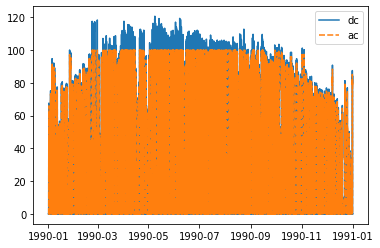

In [16]:
# Quick Production Time Series
sns.lineplot(data=df.loc[:,['dc', 'ac']])

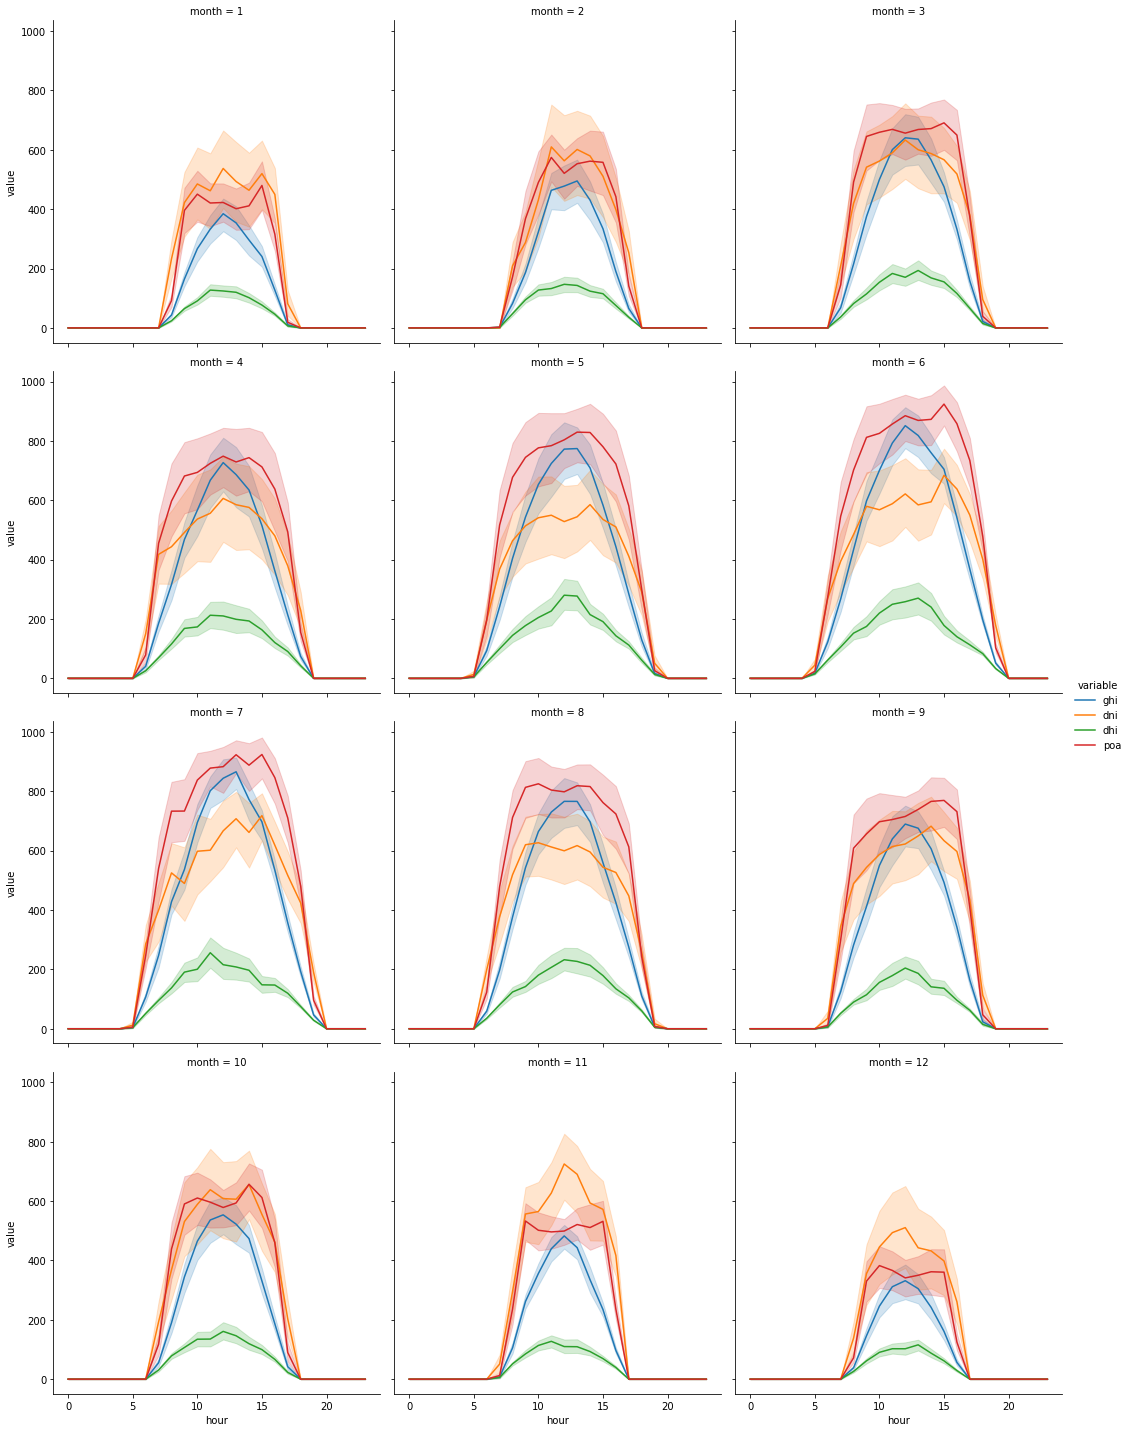

In [17]:
# Monthly Effective Irradiance
data = tidy_df[(tidy_df.variable != 'dc') & (tidy_df.variable != 'ac')]

sns.relplot(data=data, x='hour', y='value',
            hue='variable', col='month',
            col_wrap=3, kind='line')

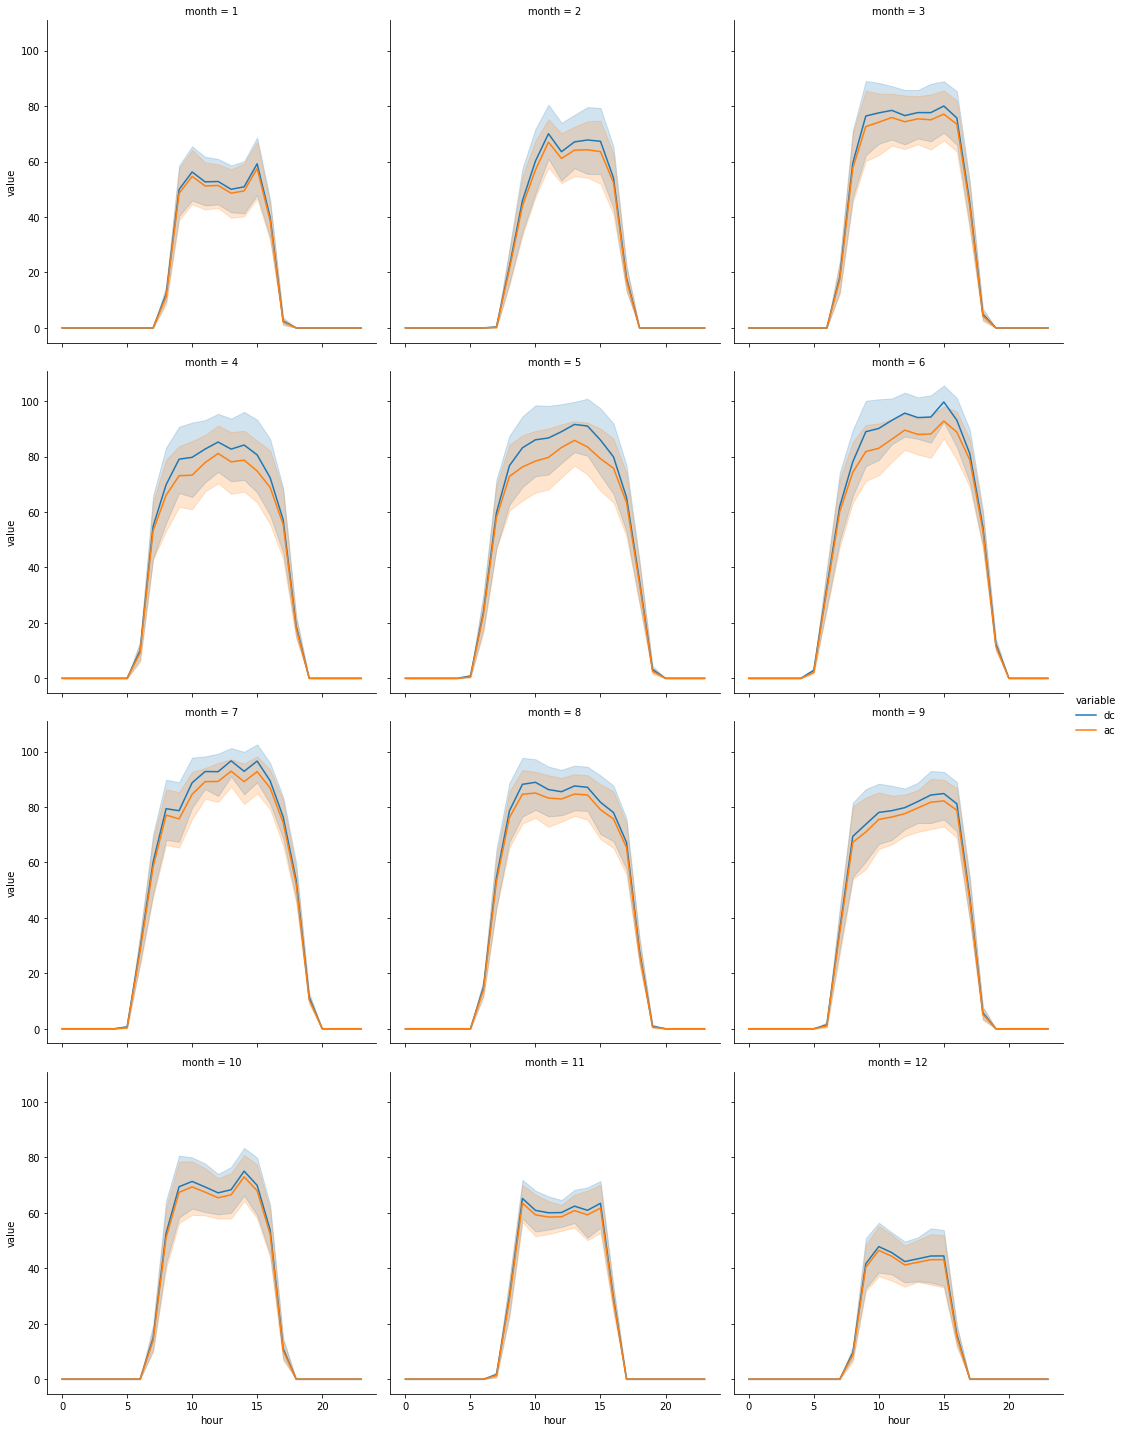

In [18]:
# Monthly Production
data = tidy_df[(tidy_df.variable == 'dc') | (tidy_df.variable == 'ac')]

sns.relplot(data=data, x='hour', y='value',
            hue='variable', col='month',
            col_wrap=3, kind='line')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

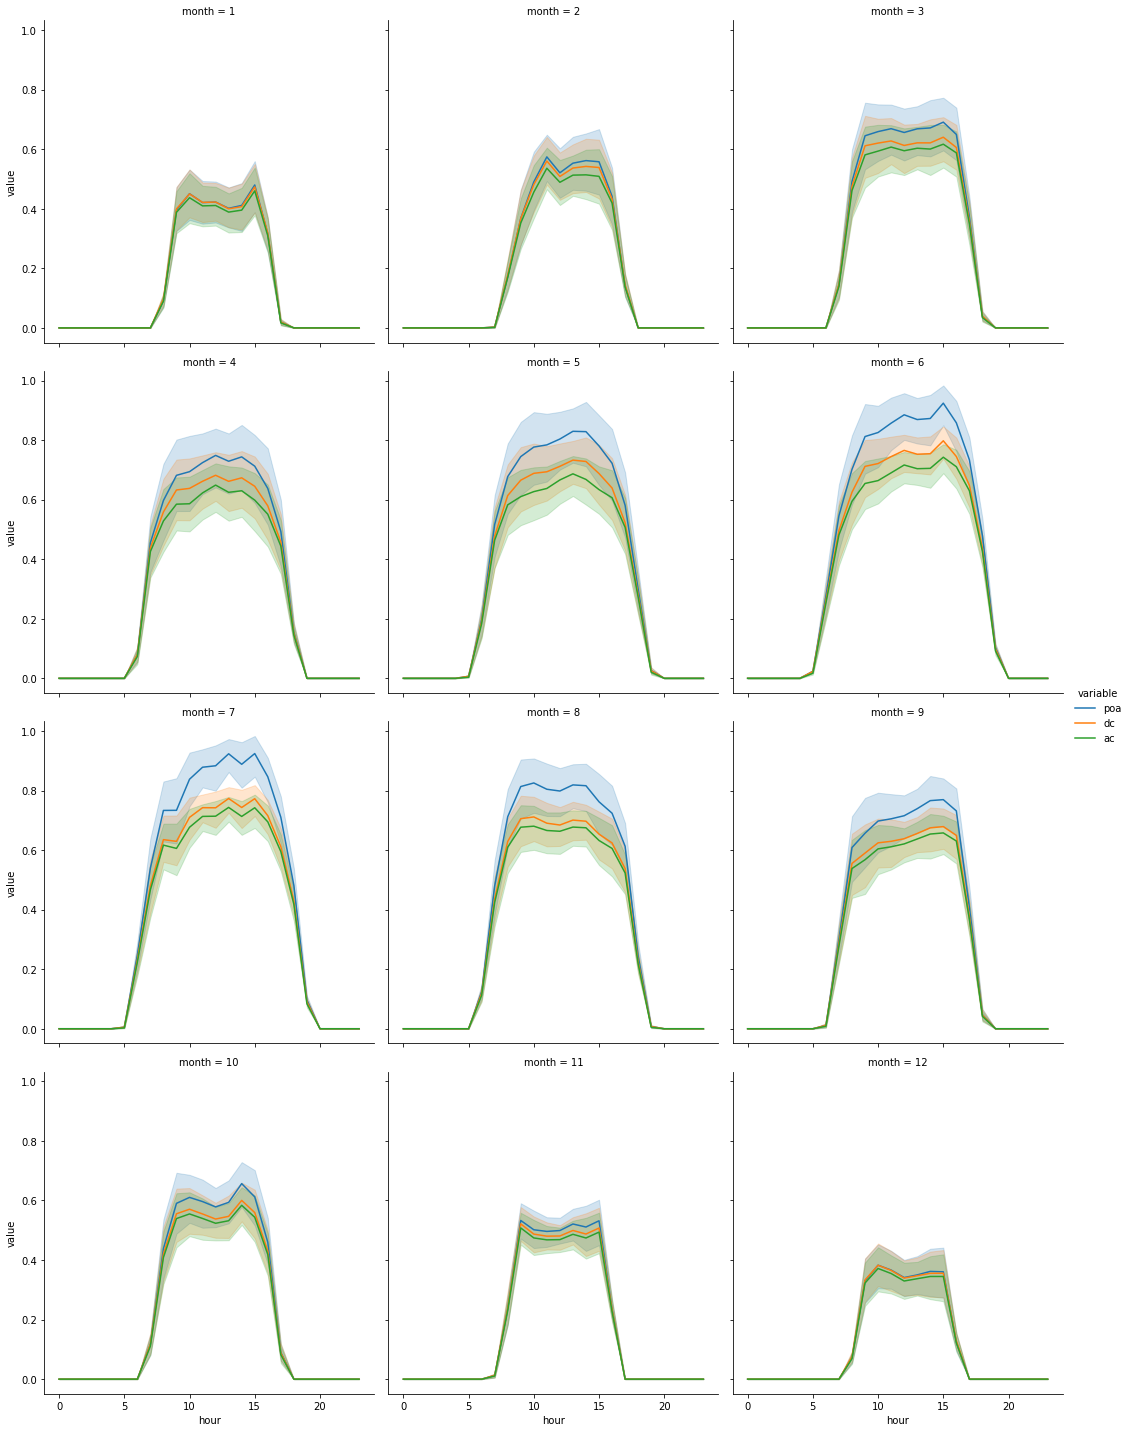

In [19]:
# Normalized POA vs. Production
data = tidy_df[(tidy_df.variable == 'dc') | (tidy_df.variable == 'ac') | (tidy_df.variable == 'poa')]
data.value[data.variable == 'dc'] = data.value[data.variable == 'dc'] / plant_mw_dc
data.value[data.variable == 'ac'] = data.value[data.variable == 'ac'] / plant_mw_dc
data.value[data.variable == 'poa'] = data.value[data.variable == 'poa'] / 1000

sns.relplot(data=data, x='hour', y='value',
            hue='variable', col='month',
            col_wrap=3, kind='line')

# Model / Losses Outline:
* Irradiance (transposition models, spectral irradiance, Incidence Angle Modifiers)
  * Soiling, Shading (electrical loss and irradiance)
  * Rear-specific losses: shading, soiling, mismatch, diffuse reflection
  * Module bifaciality to convert rear irradiance into "effective irradiance"
* Cell Temp (sapm, pvsyst, etc.)
* DC Conversion model: Single-Diode Model,  PVWatts DC Model, etc.
  * DC Capacity Adjustments:
    * PVWatts = capacity adjustment,
    * single-diode model = new voltage/current params
  * Each capacity adjustment can have its own model, which then gets combined in a dc_adjustment function, which must be aware of the dc_model being used (% adjustment to DC capacity or changes to I-V curve?
   * Mismatch: String, Module, Shading
   * Module Capacity Adjustment due to bins being +5W
   * Degradation: Should be able to model as a timeseries or scalar
* DC Cabling Losses (% voltage drop vs. ohmic)
  * Detailed: update Single Diode Model by adding resistance [PVSyst](https://www.pvsyst.com/help/ohmic_loss.htm)
  * Simpler: % loss due to resistance at all power outputs (conservative)
* Inverter model (PVWatts AC Model, etc.)
  * Temp / altitude derate, Power Factor
  * Inverter self-consumption (and nighttime losses)
* AC Losses
 * Medium Voltage Transformer Model
   * Fixed, variable losses (nighttime consumption)
 * AC Cabling (and connection) losses (which contribute to nighttime consumption)
 * Main Power Transformer Model
   * Fixed, variable losses (nighttime consumption)
 * Transmission losses
 * Interconnection limit (clipping)
   * Technically is a change in the dc model (an adjustment to the operating point on the I-V curve) but can be modeled at a high-level as a limit at the POI
* Intermittent Losses
 * Losses that occur, but which aren't planned
 * Availability and Grid Curtailment
 * Should be included in the P50 Annual Energy Production calculation but need special consideration when doing a timeseries analysis
   * Can be modeled by randomly assigning downtime during the year or looking at interconnection congestion historically

# Potential structure for loss models

```
call_dc_model
  get_adjusted_dc_params
    if dc_model == pvwatts
      calc and combine percentage losses
    elif dc_model == single_diode
      calc and update single_diode param adjustments
  run_dc_model_with_adjusted_params
```

